### bd CPS seasonal adjustment

----

Brian Dew, @bd_econ

September 20, 2019

-----

Use [Census X13as](https://www.census.gov/srd/www/x13as/) program to seasonally adjust CPS data. 

In [1]:
import pandas as pd
import statsmodels.api as sm
import os
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'

os.chdir('/home/brian/Documents/CPS/data/clean/')

from statsmodels.tsa.x13 import (_find_x12, x13_arima_select_order,
                                 x13_arima_analysis)

First, let's look at some variables from the bd CPS:

In [2]:
cols = ['MONTH', 'BASICWGT', 'AGE', 'LFS', 'FEMALE', 'MARRIED', 'WBHAO']
pd.read_feather('cps2019.ft', columns=cols).head(10)

,MONTH,BASICWGT,AGE,LFS,FEMALE,MARRIED,WBHAO
0,7,1637.476807,63,Employed,1,1,White
1,7,1649.725464,65,NILF,0,1,White
2,7,1734.040649,80,NILF,1,0,White
3,7,1916.892456,51,Employed,1,1,White
4,7,1811.555542,51,Employed,0,1,White
5,7,0.000000,12,nan,0,0,White
6,7,1586.036499,19,Employed,0,0,White
7,7,2624.587646,49,Employed,0,1,Black
8,7,2028.514648,59,NILF,1,0,Black
9,7,1565.000000,64,NILF,0,1,White


I'd like to look at labor force participation rates for some unpublished subgroups. For example, unmarried white or black women age 25-54. 

In [3]:
lfpr = lambda x: 1 - (x.loc[x['LFS'] == 'NILF', 'BASICWGT'].sum() / x.BASICWGT.sum())
wb = ['White', 'Black']

In [4]:
d = {}
for year in range(1989, 2021):
    df = (pd.read_feather(f'cps{year}.ft', columns=cols)
            .query('25 <= AGE <=54 and MARRIED == 0 and WBHAO in @wb'))
    res = df.groupby('MONTH').apply(lfpr)
    for month, rate in res.iteritems():
        d[f'{year}-{str(month).zfill(2)}-01'] = rate

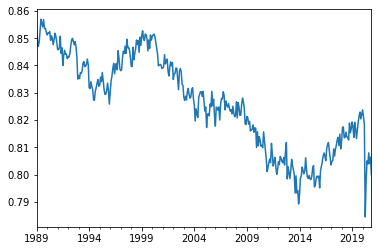

In [5]:
%matplotlib inline
data = pd.Series(d, index=pd.to_datetime(list(d.keys())))
data.plot();

There seems to be a cyclical component that has picked up since 2014. To isolate trends, particularly in recent months, one option is to apply a moving average. 

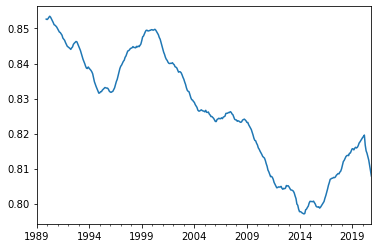

In [6]:
data.rolling(12).mean().plot();

Because the latest data in the moving average represents only 1/12th of the latest datapoint, and I am interested in the latest datapoint having more weight, another option is to apply seasonal adjustment.

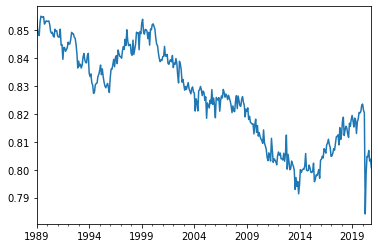

In [7]:
sm = x13_arima_analysis(data)
sm.seasadj.plot();

### Results

The Census program trend option provides a nice way to smooth noisy data without watering down the latest values or creating a lag.

<AxesSubplot:>

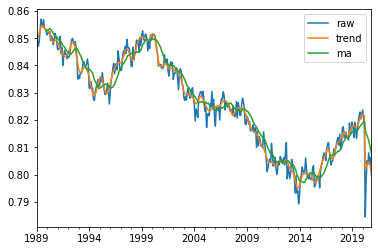

In [8]:
df = pd.DataFrame()
df['raw'] = data
df['trend'] = sm.trend
df['ma'] = data.rolling(12).mean()
df.plot()